In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-10-06 12:17:11.355530: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 12:17:11.408616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


In [3]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/home/willy98/archivos/Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:
    ruta_list = ruta.split('/')
    clase = ruta_list[7]
    number = ruta_list[8]
    tipo = ruta_list[9]
    name = ruta_list[10].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','class','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','class','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','class','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['class'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 927
MF1: - secas:  378
MF2: - secas:  288
MF3: - secas:  261


,name,route_image,class,number,route_mask
74,IMG_20230602_221151_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,4,/home/willy98/archivos/Datasets/Micrografías_s...
327,IMG_20230707_180542_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
678,IMG_20230711_174711_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,5,/home/willy98/archivos/Datasets/Micrografías_s...
408,IMG_20230707_185126_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...
770,IMG_20230711_210725_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
288,IMG_20230707_173945_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,4,/home/willy98/archivos/Datasets/Micrografías_s...
186,IMG_20230707_164515_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
673,IMG_20230711_174629_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,5,/home/willy98/archivos/Datasets/Micrografías_s...
479,IMG_20230711_154110_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,1,/home/willy98/archivos/Datasets/Micrografías_s...


In [5]:
## Establecer el porcentaje de separación
prct_train = 0.8

thold1 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='0'])))
thold2 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='1'])))
thold3 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset['class'] == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset['class'] == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset['class'] == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset['class'] == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset['class'] == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset['class'] == '2'][thold3:]

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  231 , test:  57
Clase MF3: train:  209 , test:  52


In [6]:
### Definir datasets de training y test
# Todas las clases
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

# solo una clase
#train_df = train_cu2
#test_df = test_cu2

train_df

,name,route_image,class,number,route_mask
327,IMG_20230707_180542_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
408,IMG_20230707_185126_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...
105,IMG_20230707_161812_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
102,IMG_20230707_161741_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
336,IMG_20230707_180650_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
893,IMG_20230711_215343_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,6,/home/willy98/archivos/Datasets/Micrografías_s...
801,IMG_20230711_211722_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
72,IMG_20230602_221125_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,4,/home/willy98/archivos/Datasets/Micrografías_s...
783,IMG_20230711_211208_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...


In [1]:
## Crear objetos transformadores
## Para entrenamiento
SEED = 100

img_generator_images = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

img_generator_mask = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator_IMAGES = img_generator_images.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_image",
    y_col="class",
    labels = ['MF1','MF2','MF3'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

train_generator_MASK = img_generator_mask.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_mask",
    y_col="class",
    labels = ['MF1','MF2','MF3'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

NameError: name 'tf' is not defined

In [8]:
X_train_images = []
train_mask = []
label_train_images  = []
label_train_mask = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator_IMAGES.next()

    X_train_images.extend(x)
    label_train_images.extend(y)
    
for i in range(batches):
    
    x,y = train_generator_MASK.next()

    train_mask.extend(x)
    label_train_mask.extend(y)
    
    
print(np.shape(train_mask),np.shape(train_mask))
print(np.array_equal(label_train_mask,label_train_images))

(2975, 128, 128, 1) (2975, 128, 128, 1)
True


1.0 1.0


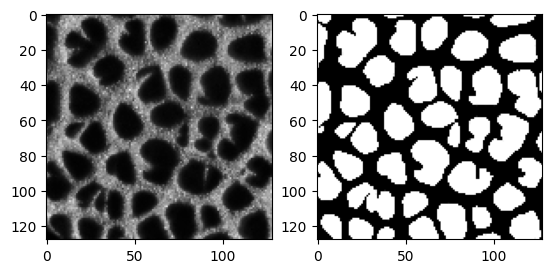

In [9]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(train_mask[n],cmap='gray')
ax1.imshow(X_train_images[n],cmap='gray')
print(label_train_mask[n],label_train_images[n])
plt.show()

In [10]:
test_df

,name,route_image,class,number,route_mask
296,IMG_20230707_174054_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,4,/home/willy98/archivos/Datasets/Micrografías_s...
353,IMG_20230707_180855_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
249,IMG_20230707_171243_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,3,/home/willy98/archivos/Datasets/Micrografías_s...
450,IMG_20230707_191619_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
409,IMG_20230707_185130_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
73,IMG_20230602_221139_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,4,/home/willy98/archivos/Datasets/Micrografías_s...
781,IMG_20230711_211134_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
870,IMG_20230711_214828_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,6,/home/willy98/archivos/Datasets/Micrografías_s...
924,IMG_20230711_223139_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,5,/home/willy98/archivos/Datasets/Micrografías_s...


In [11]:
## Dataset de prueba
test_df_shuffled = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_images = []
y_test_images = []
X_test_mask = []
y_test_mask = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df_shuffled)):
    
    #Capturar ruta y label
    ruta_img = test_df_shuffled.iloc[i].route_image
    label_img = test_df_shuffled.iloc[i]['class']
    ruta_mask = test_df_shuffled.iloc[i].route_mask
    label_mask = test_df_shuffled.iloc[i]['class']
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta_img,color_mode='grayscale')
    msk = tf.keras.preprocessing.image.load_img(ruta_mask,color_mode='grayscale')
    
    X_test_images.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_images.append(label_img)
    
    X_test_mask.append(tf.keras.preprocessing.image.img_to_array(msk.resize((nsize,nsize))))
    y_test_mask.append(label_mask)
    
print('Test: images->',np.shape(X_test_images),' label ->',np.shape(y_test_images))
print('Test: mask->',np.shape(X_test_mask),' label ->',np.shape(y_test_mask))

Test: images-> (184, 128, 128, 1)  label -> (184,)
Test: mask-> (184, 128, 128, 1)  label -> (184,)


In [12]:
x_train_images = np.array(X_train_images)
x_test_images = np.array(X_test_images)

x_train_images = x_train_images.astype('float32')
x_test_images= x_test_images.astype('float32')
 
#y_test_images = tf.keras.utils.to_categorical(y_test_images)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_images /= 255

print('x_train shape:', x_train_images.shape)
print('Number of images in x_train', x_train_images.shape, "y_train:", np.shape(label_train_images))
print('Number of images in x_test', x_test_images.shape, "y_test: ", np.shape(y_test_images))

x_train shape: (2975, 128, 128, 1)
Number of images in x_train (2975, 128, 128, 1) y_train: (2975,)
Number of images in x_test (184, 128, 128, 1) y_test:  (184,)


0 0


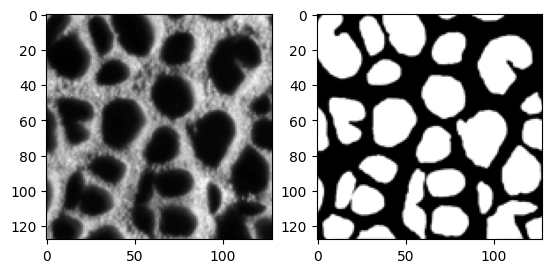

In [13]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(X_test_mask[n],cmap='gray')
ax1.imshow(X_test_images[n],cmap='gray')
print(y_test_mask[n],y_test_mask[n])
plt.show()

### Cargar Modelo

In [62]:
class encoder_block(layers.Layer):
    
    ## Inicializar la clase de capa convolucional
    def __init__(self,out_channels,kernel_size=(3, 3)):
        ## conv y bn son las dos capas (que contienen pesos) del bloque/clase
        super(encoder_block, self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, activation='relu', padding='same')
        self.pooling = layers.MaxPooling2D()
        self.bn = layers.BatchNormalization()       
    
    
    ## The call method is the same as the forward method of the block
    def call(self, input_tensor,training = False):
        x = self.conv(input_tensor)
        x = self.pooling(x)
        x = self.bn(x,training = training)           
        
        return x
    
    def call_last_conv_layer(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.pooling(x)
        
        return x
        

    
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class Encoder(keras.Model):
    
    def __init__(self,name = 'encoder',n_dims=128,**kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)         
        ## Bloque convolucional:
        self.block1 = encoder_block(1024)
        self.block2 = encoder_block(1024)
        self.block3 = encoder_block(512)
        self.block4 = encoder_block(128)
        self.block5 = encoder_block(64)
        self.final_cov = layers.Conv2D(16,(3,3), activation='relu', padding='same')
        self.flattening = layers.Flatten()
        self.z_mean = layers.Dense(n_dims)
        self.z_logvar = layers.Dense(n_dims)
        self.embedding = Sampling()
        
        
        
    def call(self, tensor_input):
        x = self.block1(tensor_input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.final_cov(x)
        x = self.flattening(x)
        mu = self.z_mean(x)
        logvar = self.z_logvar(x)
        z = self.embedding([mu,logvar])
        
        
        return [mu,logvar,z]
    
    def call_embedding(self, tensor_input):
        x = self.block1(tensor_input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.final_cov(x)
        
        return x
    

class decoder_block(layers.Layer):
    
    def __init__(self,out_channels,kernel_size=(3,3),size_upsam = (2,2)):
        super(decoder_block,self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, activation='relu', padding='same')
        self.upsam = layers.UpSampling2D(size=size_upsam)  
        self.bn = layers.BatchNormalization()   
        
    def call(self,input_tensor,training = False):
        x = self.conv(input_tensor)
        x = self.upsam(x)
        x = self.bn(x, training = training)
        
        
        return x
    
class Decoder(keras.Model):
    
    def __init__(self,name = 'decoder',**kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.firts_layer = layers.Dense(8*8*64,activation = 'relu') 
        self.block1 = decoder_block(64)
        self.block2 = decoder_block(32)
        self.block3 = decoder_block(16,size_upsam =(4,4))        
        self.conv = layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        self.final = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')    
        
        
    def call(self, embedding_input):
        embedding_input = self.firts_layer(embedding_input)
        x = tf.reshape(embedding_input,[-1,8,8,64])
        x = self.block1(x)       
        x = self.block2(x) 
        x = self.block3(x)        
        x = self.conv(x)
        out = self.final(x)
        
        return out

class VAE(keras.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        ##Variables que guardan paso a paso las pérdidas
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')        
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            ## Generar embebidos
            z_mean, z_log_var, z = self.encoder(data)
            
            ## Reconstruir embebidos
            reconstruction = self.decoder(z)
            
            ## Normalizar reconstrucciones
            reconstruction /= tf.reduce_max(reconstruction)
            
            ## Calcular la diferencia binaria entre las imágenes de entrada y las reconstrucciones
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )         
            
            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            ## Pérdida de kullback leibler
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))            
        
            ## Pérdida total
            total_loss = reconstruction_loss + kl_loss     
            
        ## Calcular los gradientes 
        grads = tape.gradient(total_loss, self.trainable_weights)       

        ## Guardar reconstrucciones en una variable propia del modelo
        self.reconstruction = reconstruction

        ## Calcular gradientes entre los pesos            
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        ## Actualizar la variable de pérdida total
        self.total_loss_tracker.update_state(total_loss)

        ## Actualizar la variable de pérdida de reconstrucción
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)       

        ## Actualizar la variable de pérdida por kull-back
        self.kl_loss_tracker.update_state(kl_loss)       

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(), 
            'kl_loss':self.kl_loss_tracker.result(),
        }
    
VAE_encoder = Encoder()
VAE_decoder = Decoder()

In [63]:
### Cargar modelo
encd = keras.models.load_model('Models/GVAE_3_encoder_dry_128')
decd = keras.models.load_model('Models/GVAE_3_decoder_dry_128')

## Call the subclassed model once to create the weights.
test_array = np.random.random([1,128,128,1])
test_emb = encd.predict(test_array)
test_reconst = decd.predict(test_emb[0])

## Save weights
encd.save_weights('Models/GVAE_3_encoder_dry_128_weights',save_format="tf")
decd.save_weights('Models/GVAE_3_decoder_dry_128_weights',save_format="tf")

## Load weights
VAE_encoder.load_weights('Models/GVAE_3_encoder_dry_128_weights')
VAE_decoder.load_weights('Models/GVAE_3_decoder_dry_128_weights')

1/1 [==============================] - 0s 98ms/step


In [64]:
data_train = x_train_images
data_test = x_test_images

label_train = label_train_images
label_test = y_test_images

# Embebidos del encoder
encoder_embds  = VAE_encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = VAE_encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))


93/93 [==============================] - 26s 283ms/step
Shape_embs:  (3, 2975, 128)
6/6 [==============================] - 1s 284ms/step
Shape_embs:  (3, 184, 128)


In [65]:
np.shape(data_train)

(2975, 128, 128, 1)

In [66]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 16
dmy = 8

np.shape(encoder_embds[D])

(2975, 128)

In [67]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = VAE_decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds[D]))

93/93 [==============================] - 1s 4ms/step
(2975, 128, 128, 1) (2975, 128)


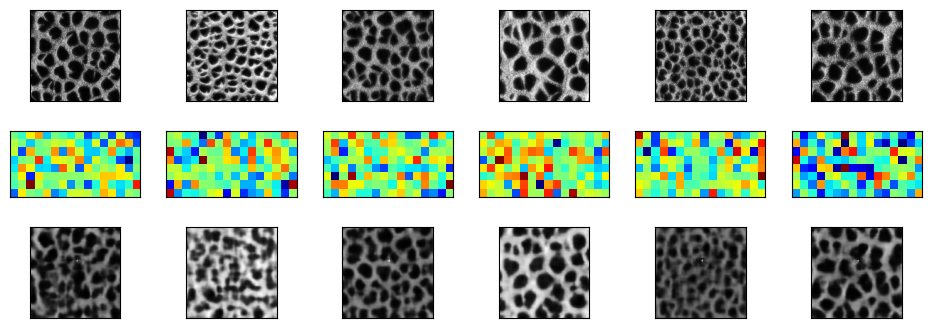

In [68]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_train[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds[D][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [69]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs_test = VAE_decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

6/6 [==============================] - 0s 3ms/step
(184, 128, 128, 1) (3, 184, 128)


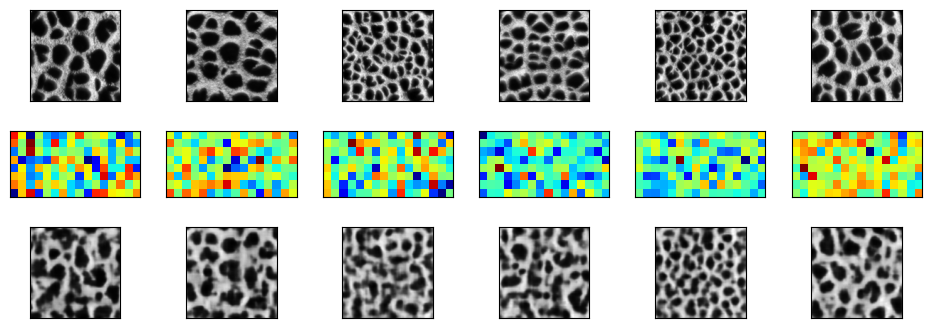

In [70]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds_test[D][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [71]:
pca_data = PCA(n_components=2)
PCA_2dim = pca_data.fit_transform(encoder_embds[D])
PCA_2dim.shape

(2975, 2)

In [72]:
labels_text = pd.DataFrame(label_train_images).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text.shape

(2975, 1)

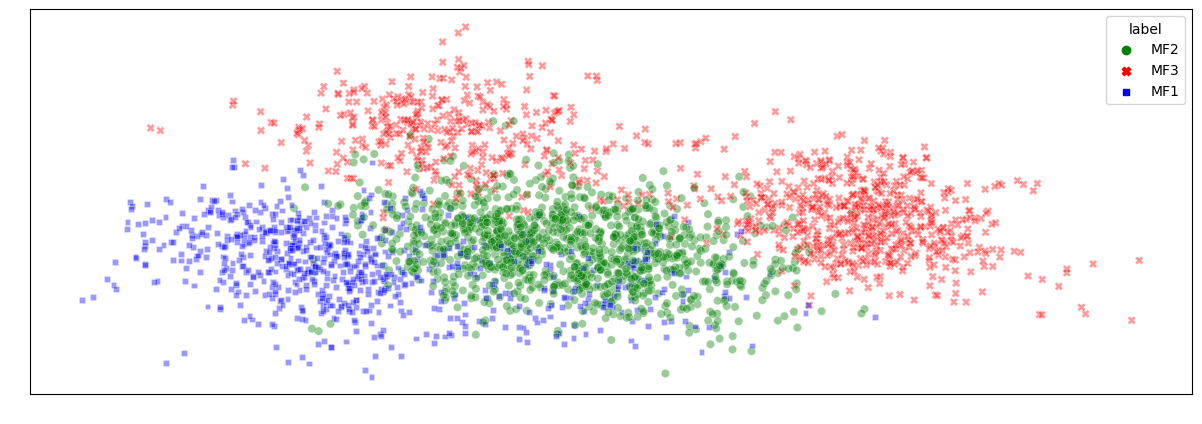

In [73]:
data_img = pd.DataFrame()                 
data_img['x'] = PCA_2dim[:,0]
data_img['y'] = PCA_2dim[:,1]
data_img['label'] = pd.DataFrame(labels_text)


plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img.x,y=data_img.y,hue='label',data=data_img, style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
#plt.legend(fontsize="18")
#plt.xticks(range(-5, 5))
#plt.grid()

plt.show()

In [74]:
labels_text_test = pd.DataFrame(y_test_images).replace({'0': "MF1", '1': "MF2",'2': "MF3"})
labels_text_test.shape

(184, 1)

In [75]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(184, 2)

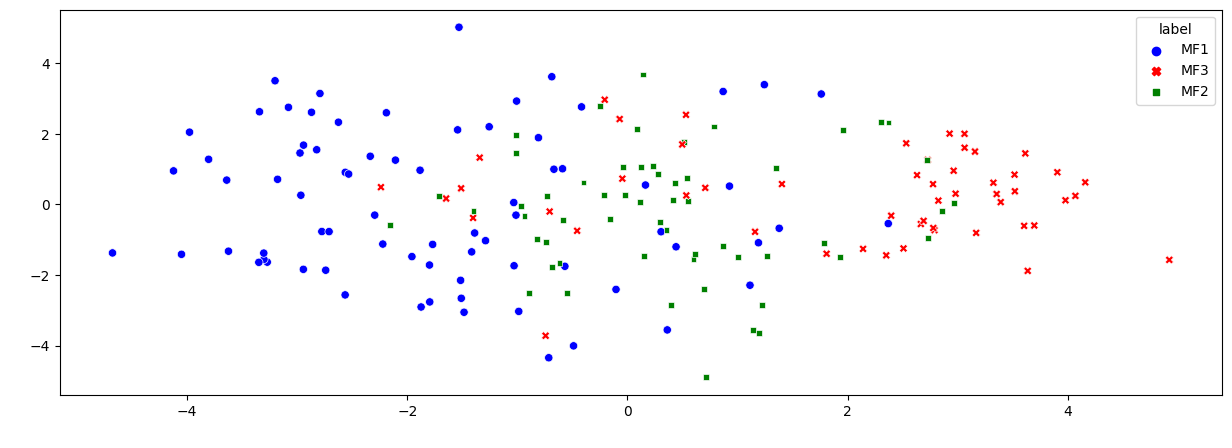

In [77]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()